# Udemy course: TensroFlow Developer certificate in 2023: Zero to Mastery Section 9


In [2]:
# Check TensorFlow version
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


In [3]:
# will be using a TensorFlow dataset
import tensorflow_datasets as tfds

# list of available datasets
datasets_list = tfds.list_builders()
print(datasets_list[:5], len(datasets_list))



['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset'] 1261


In [4]:
# Select a dataset and confirm that it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [106]:
# Load in the data from tensroflow datasets
# https://www.tensorflow.org/datasets/catalog/food101
(train_data, test_data), ds_info = tfds.load(name="food101", # name of the target dataset to get from TFDS (a string)
                                             split=["train", "validation"], # the splits of data, not all datasets have train, validation and test. This one only has 'train' and 'validation'
                                             shuffle_files=True, # shuffle when downloading
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label).
                                             with_info=True) # tfds.load() returns tuple (data, ds_info)

In [7]:
# get the classes names through dataset_info.features()
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# extract the clsses names
class_names = ds_info.features["label"].names

#check the name of the first 10 classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# Dataset exploration

In [9]:
# sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:

for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 74
  Class name (str form): peking_duck
        


In [11]:
# min and max values in tensors
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Not all the images in the dataset have the same shape

The images are not scaled with tensor values between 0 and 255

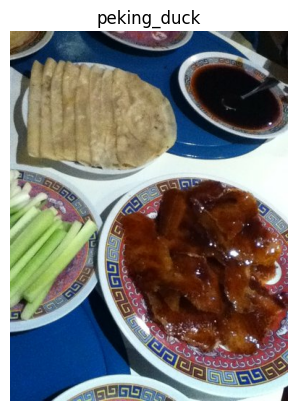

In [12]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

## Preprocess the data

Data is int unit8 datatype, data tensors have multiple sizes, the tensors are not scaled/normalized

create a preprocess_img() that will convert the datasets into a format that is ready to use in modeling:

* Convert datatype to float32 -  using tf.cast()
* reshape tensors so that all have the same size: (224,224,3) -  using tf.image.resize()
* nomalize the values to tht there are between 0 & 1 - by deviding tensor by 255

In [13]:
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [14]:
# Preprocess one sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"""Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n""")
print(f"""Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n""")

Image before preprocessing:
 [[[152 129  77]
  [160 137  85]
  [160 137  85]
  ...
  [ 26  21  18]
  [ 24  19  16]
  [ 21  16  13]]

 [[156 133  81]
  [158 135  83]
  [155 132  80]
  ...
  [ 25  20  17]
  [ 23  18  15]
  [ 22  17  14]]]...,
Shape: (512, 384, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[156.05103  133.05103   81.05102 ]
  [156.13776  133.13776   81.13776 ]
  [146.31122  123.311226  71.311226]
  ...
  [ 22.454105  17.454105  13.668401]
  [ 25.306135  20.306135  17.306135]
  [ 22.25511   17.25511   14.25511 ]]

 [[159.82652  136.82652   82.82653 ]
  [149.79591  126.79591   72.79591 ]
  [132.69388  109.69388   57.26531 ]
  ...
  [ 24.183672  19.183672  15.397966]
  [ 22.21425   17.21425   14.214251]
  [ 18.83164   14.83164   11.83164 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>



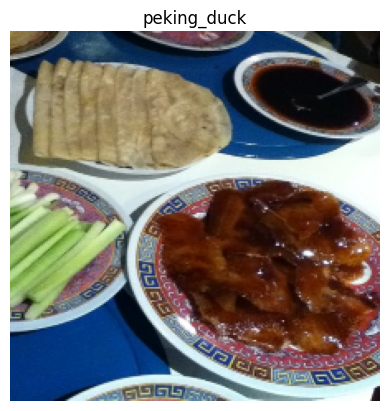

In [15]:
plt.imshow(preprocessed_img/255.) # for imshow the image/tensor has to be scaled/normalized
plt.title(class_names[label])
plt.axis(False);

## Batch & prepare the dataset

* create batches (computing on batchs is memory efficient)

Convert image tensors and lables into batches of 32 image, label pairs - use metrhods from tf.data


Process:
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset




In [16]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it
# Prefetch allows later elements to be prepared while the current element is being
# processed. This often improves latency and throughput, at the cost of
# using additional memory to store prefetched elements.
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches shuffling is not needed
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Create modelling callbacks

In [17]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

In [18]:
# Mixed precision training
# Uses a mix of float16 and float32 tensors to make better use of your GPU's memory.

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision
mixed_precision.global_policy()

<Policy "mixed_float16">

In [19]:
## Build feature extraction model
# Base model: EfficientNetB0

from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # exclude top layer this will be replaced by a new output layer appropriate for what is being modeled
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot as is the case for this dataset
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [21]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [22]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # checking only the first 20 layes
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [23]:
## Fit the feature extraction model

# create tensorboard callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instance to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240107-183831
Epoch 1/3
2368/2368 [==============================] - 192s 76ms/step - loss: 1.7159 - accuracy: 0.5831 - val_loss: 1.1271 - val_accuracy: 0.6989
Epoch 2/3
2368/2368 [==============================] - 173s 72ms/step - loss: 1.1987 - accuracy: 0.6893 - val_loss: 1.0328 - val_accuracy: 0.7145
Epoch 3/3
2368/2368 [==============================] - 175s 73ms/step - loss: 1.0539 - accuracy: 0.7230 - val_loss: 0.9898 - val_accuracy: 0.7259


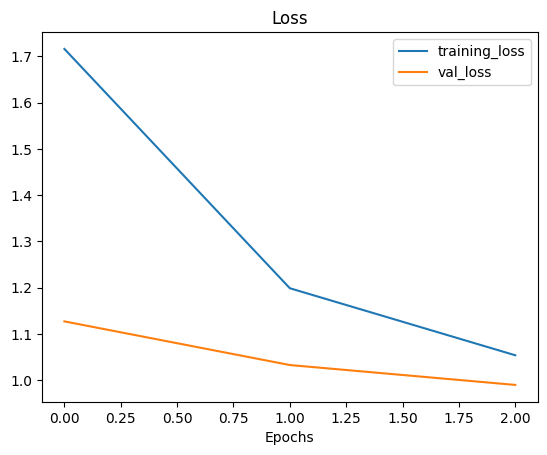

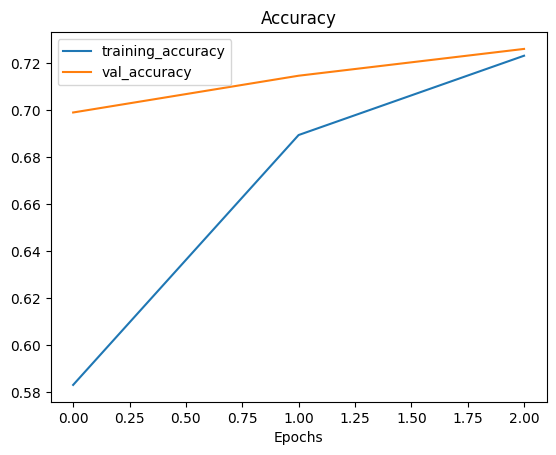

In [24]:
import matplotlib.pyplot as plt

def plot_loss_accuracy_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


plot_loss_accuracy_curves(history_101_food_classes_feature_extract)

In [25]:
# Evaluate model on the  whole test dataset (only 15% was used during training)
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 52s 65ms/step - loss: 1.0001 - accuracy: 0.7282


[1.000064492225647, 0.7281584143638611]

In [26]:

## Load and evaluate checkpoint weights

# Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# Load the saved weights
created_model.load_weights(checkpoint_path)

# Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

790/790 [==============================] - 52s 62ms/step - loss: 1.0001 - accuracy: 0.7282


In [27]:
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close


## Save the whole model to file


In [28]:
# Save model locally
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [29]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [30]:
# Check loaded model performance
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 53s 64ms/step - loss: 1.0001 - accuracy: 0.7282


[1.0000643730163574, 0.7281584143638611]

In [31]:
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all() # results variables  had to be instatiated

## Fine-tuning

In [32]:
loaded_saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [33]:
for layer in loaded_saved_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [34]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss does not decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [35]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [36]:
# Compile the model
loaded_saved_model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [37]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements


Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20240107-185123
Epoch 1/100
2368/2368 [==============================] - 459s 172ms/step - loss: 0.8718 - accuracy: 0.7644 - val_loss: 0.7928 - val_accuracy: 0.7752 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 404s 170ms/step - loss: 0.5381 - accuracy: 0.8512 - val_loss: 0.7746 - val_accuracy: 0.7892 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 373s 156ms/step - loss: 0.3015 - accuracy: 0.9144 - val_loss: 0.8490 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9533
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 378s 159ms/step - loss: 0.1595 - accuracy: 0.9533 - val_loss: 0.9242 - val_accuracy: 0.7826 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 370s 15

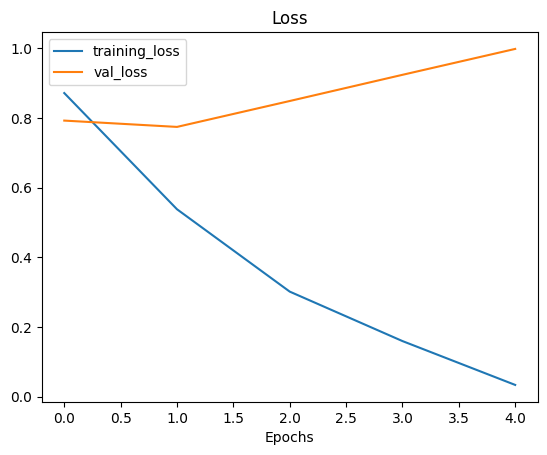

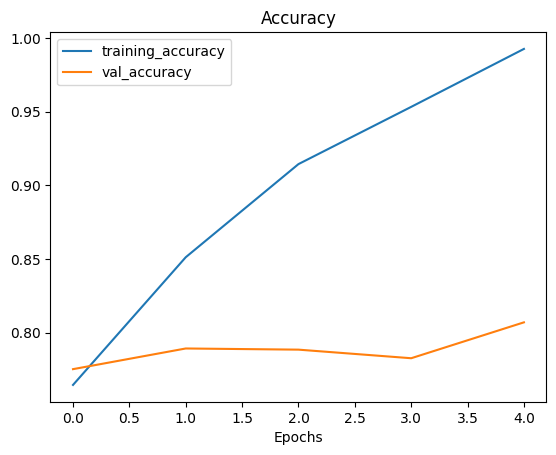

In [38]:


plot_loss_accuracy_curves(history_101_food_classes_all_data_fine_tune)

In [39]:
# Evaluate model on the  whole test dataset (only 15% was used during training)
results_101_food_classes_all_data_fine_tune = loaded_saved_model.evaluate(test_data)
results_101_food_classes_all_data_fine_tune

790/790 [==============================] - 54s 68ms/step - loss: 1.0150 - accuracy: 0.8040


[1.0149575471878052, 0.8040395975112915]

# there is a lot of overfitting when all layers are set to trainable.

# How does the model behave if only a set of layers are unfreezed?

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [41]:
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in model (feature extraction): ", len(model.layers))

Number of layers in the base model:  238
Number of layers in model (feature extraction):  5


In [42]:
# unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.
# the later layers contain the fine details that are more specific to the problem in hand
# Where the final layers actually begin is arbitrary (a parameter that can be adjusted)

# We unfreeze the top 50 layers while leaving BatchNorm layers frozen
for layer in base_model.layers[-50:]:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True


# Recompile model with lower learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])





In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
pooling_layer True
dense True
softmax_float32 True


In [43]:
#accessing the layer effi9cientnetb0 to check if the last 50 layers had changed to trainable with exception of the BacthNorm
for layer in model.layers[1].layers[-60:]:
  print(layer.name, layer.trainable)

block6b_expand_bn False
block6b_expand_activation False
block6b_dwconv False
block6b_bn False
block6b_activation False
block6b_se_squeeze False
block6b_se_reshape False
block6b_se_reduce False
block6b_se_expand False
block6b_se_excite False
block6b_project_conv True
block6b_project_bn False
block6b_drop True
block6b_add True
block6c_expand_conv True
block6c_expand_bn False
block6c_expand_activation True
block6c_dwconv True
block6c_bn False
block6c_activation True
block6c_se_squeeze True
block6c_se_reshape True
block6c_se_reduce True
block6c_se_expand True
block6c_se_excite True
block6c_project_conv True
block6c_project_bn False
block6c_drop True
block6c_add True
block6d_expand_conv True
block6d_expand_bn False
block6d_expand_activation True
block6d_dwconv True
block6d_bn False
block6d_activation True
block6d_se_squeeze True
block6d_se_reshape True
block6d_se_reduce True
block6d_se_expand True
block6d_se_excite True
block6d_project_conv True
block6d_project_bn False
block6d_drop True
bl

In [44]:
# Fine-tune for 7 more epochs
fine_tune_epochs = 10 # model has already done 3 epochs, this is the total number of epochs we're after (3+7=10)

history_101_food_classes_finetuning50 = model.fit(train_data,
                                                  epochs=fine_tune_epochs,
                                                  steps_per_epoch=len(train_data),
                                                  validation_data=test_data,
                                                  validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                  initial_epoch=history_101_food_classes_feature_extract.epoch[-1], # start from prev
                                                  callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "history_101_food_classes_finetuning50"),
                                                  model_checkpoint])



Saving TensorBoard log files to: training_logs/history_101_food_classes_finetuning50/20240107-192535
Epoch 3/10
2368/2368 [==============================] - 187s 73ms/step - loss: 0.8901 - accuracy: 0.7728 - val_loss: 0.9571 - val_accuracy: 0.7394
Epoch 4/10
2368/2368 [==============================] - 173s 72ms/step - loss: 0.8734 - accuracy: 0.7773 - val_loss: 0.9627 - val_accuracy: 0.7365
Epoch 5/10
2368/2368 [==============================] - 176s 73ms/step - loss: 0.8626 - accuracy: 0.7804 - val_loss: 0.9484 - val_accuracy: 0.7415
Epoch 6/10
2368/2368 [==============================] - 174s 72ms/step - loss: 0.8534 - accuracy: 0.7831 - val_loss: 0.9519 - val_accuracy: 0.7413
Epoch 7/10
2368/2368 [==============================] - 174s 73ms/step - loss: 0.8448 - accuracy: 0.7849 - val_loss: 0.9517 - val_accuracy: 0.7421
Epoch 8/10
2368/2368 [==============================] - 171s 71ms/step - loss: 0.8366 - accuracy: 0.7886 - val_loss: 0.9500 - val_accuracy: 0.7402
Epoch 9/10
2368/2

In [45]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()





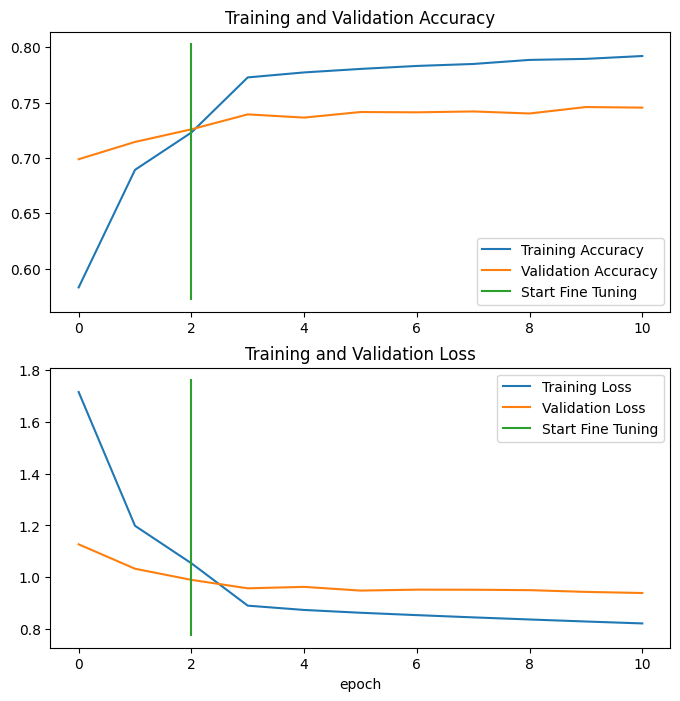

In [46]:
compare_historys(original_history=history_101_food_classes_feature_extract,
                 new_history=history_101_food_classes_finetuning50,
                 initial_epochs=3)

In [47]:
# Evaluate model on the  whole test dataset (only 15% was used during training)
results_101_food_classes_finetuning50 = model.evaluate(test_data)
results_101_food_classes_finetuning50

790/790 [==============================] - 52s 65ms/step - loss: 0.9502 - accuracy: 0.7430


[0.9501540660858154, 0.7429702877998352]

Significant less overfitting.
Difference in accuracy between training and validation sets:

Finetuning with unfreezing of last 50 layers = 4.7%
Finetuning unfreezing all layers = 18.6%

# Generate an F1-score barchart for this last model

In [68]:
predictions = []
labels = []
for x, y in test_data:
    predictions.append(np.argmax(model(x), axis=-1))
    labels.append(y.numpy())

In [69]:
print(len(predictions), len(labels))

790 790


In [71]:
print(predictions[:2], labels[:2])

[array([ 20, 100,   3,  22,  22,  59,  12,  19,  90,   6,  23,  71,  39,
        98,  82,  96,  96,  42,  38,  12,  34,  70,  55,  32,  96,  72,
        63,  91,  29,   5,   1,  27]), array([95, 99, 16,  1, 45, 34, 23, 30, 72, 45,  5,  9, 49, 18, 39, 75, 16,
       40, 90, 33,  9,  1, 78, 77, 96,  6, 48, 80, 38, 74, 43,  7])] [array([ 78, 100,   3,  73,  22,  59,  12,  39,  90,   6,  23,  44,  39,
         6,  77,  56,  96,  42,  28,  12,   4,  66,  55,  32,  19,  42,
        63,  91,  16,  97,  79,  41]), array([95,  4, 83, 80, 45, 28, 23, 30, 72, 45, 94, 92, 46, 18, 99, 75, 16,
       40, 90, 33,  9, 12, 78, 77, 96,  6, 48,  9, 38, 74, 52,  7])]


In [96]:
predictions = np.concatenate(predictions, axis=0)
labels = np.concatenate(labels, axis=0)

In [97]:
predictions[:64]

array([ 20, 100,   3,  22,  22,  59,  12,  19,  90,   6,  23,  71,  39,
        98,  82,  96,  96,  42,  38,  12,  34,  70,  55,  32,  96,  72,
        63,  91,  29,   5,   1,  27,  95,  99,  16,   1,  45,  34,  23,
        30,  72,  45,   5,   9,  49,  18,  39,  75,  16,  40,  90,  33,
         9,   1,  78,  77,  96,   6,  48,  80,  38,  74,  43,   7])

In [98]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(labels, predictions)
sklearn_accuracy

0.742970297029703

In [99]:
from sklearn.metrics import classification_report
#get the classification report that has the accuracy, precision, recall and  f1-score
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.52      0.48      0.50       250
           1       0.77      0.73      0.75       250
           2       0.77      0.79      0.78       250
           3       0.75      0.75      0.75       250
           4       0.63      0.58      0.60       250
           5       0.60      0.63      0.61       250
           6       0.85      0.82      0.83       250
           7       0.85      0.88      0.86       250
           8       0.52      0.52      0.52       250
           9       0.74      0.60      0.67       250
          10       0.65      0.60      0.62       250
          11       0.73      0.80      0.76       250
          12       0.80      0.78      0.79       250
          13       0.71      0.70      0.71       250
          14       0.77      0.71      0.74       250
          15       0.58      0.59      0.58       250
          16       0.57      0.56      0.56       250
          17       0.76    

In [100]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(labels, predictions, output_dict=True)
classification_report_dict


{'0': {'precision': 0.519650655021834,
  'recall': 0.476,
  'f1-score': 0.4968684759916493,
  'support': 250},
 '1': {'precision': 0.7679324894514767,
  'recall': 0.728,
  'f1-score': 0.7474332648870636,
  'support': 250},
 '2': {'precision': 0.7665369649805448,
  'recall': 0.788,
  'f1-score': 0.777120315581854,
  'support': 250},
 '3': {'precision': 0.749003984063745,
  'recall': 0.752,
  'f1-score': 0.750499001996008,
  'support': 250},
 '4': {'precision': 0.6266094420600858,
  'recall': 0.584,
  'f1-score': 0.6045548654244307,
  'support': 250},
 '5': {'precision': 0.5984848484848485,
  'recall': 0.632,
  'f1-score': 0.6147859922178989,
  'support': 250},
 '6': {'precision': 0.8535564853556485,
  'recall': 0.816,
  'f1-score': 0.8343558282208589,
  'support': 250},
 '7': {'precision': 0.8467432950191571,
  'recall': 0.884,
  'f1-score': 0.8649706457925637,
  'support': 250},
 '8': {'precision': 0.52, 'recall': 0.52, 'f1-score': 0.52, 'support': 250},
 '9': {'precision': 0.743842364

In [130]:

# Get the class names
class_names = pd.read_csv("/root/tensorflow_datasets/food101/2.0.0/label.labels.txt", header = None )
class_names.columns = ['class_names']
class_names

,class_names
0,apple_pie
1,baby_back_ribs
2,baklava
3,beef_carpaccio
4,beef_tartare
...,...
96,tacos
97,takoyaki
98,tiramisu
99,tuna_tartare


In [135]:
class_names.iloc[0]

class_names    apple_pie
Name: 0, dtype: object

In [137]:
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    print(k)
    class_f1_scores[class_names['class_names'][int(k)]] = v["f1-score"]
class_f1_scores

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


{'apple_pie': 0.4968684759916493,
 'baby_back_ribs': 0.7474332648870636,
 'baklava': 0.777120315581854,
 'beef_carpaccio': 0.750499001996008,
 'beef_tartare': 0.6045548654244307,
 'beet_salad': 0.6147859922178989,
 'beignets': 0.8343558282208589,
 'bibimbap': 0.8649706457925637,
 'bread_pudding': 0.52,
 'breakfast_burrito': 0.6666666666666666,
 'bruschetta': 0.6208333333333332,
 'caesar_salad': 0.761904761904762,
 'cannoli': 0.7894736842105263,
 'caprese_salad': 0.7068273092369478,
 'carrot_cake': 0.735966735966736,
 'ceviche': 0.5838264299802761,
 'cheesecake': 0.5645161290322581,
 'cheese_plate': 0.731404958677686,
 'chicken_curry': 0.6511627906976745,
 'chicken_quesadilla': 0.7632093933463798,
 'chicken_wings': 0.8133595284872298,
 'chocolate_cake': 0.6745098039215686,
 'chocolate_mousse': 0.5544554455445545,
 'churros': 0.84472049689441,
 'clam_chowder': 0.8253358925143953,
 'club_sandwich': 0.796844181459566,
 'crab_cakes': 0.6090534979423868,
 'creme_brulee': 0.8508946322067595,


In [138]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
33,edamame,0.983871
63,macarons,0.936508
54,hot_and_sour_soup,0.904110
91,spaghetti_carbonara,0.904110
75,pho,0.897233


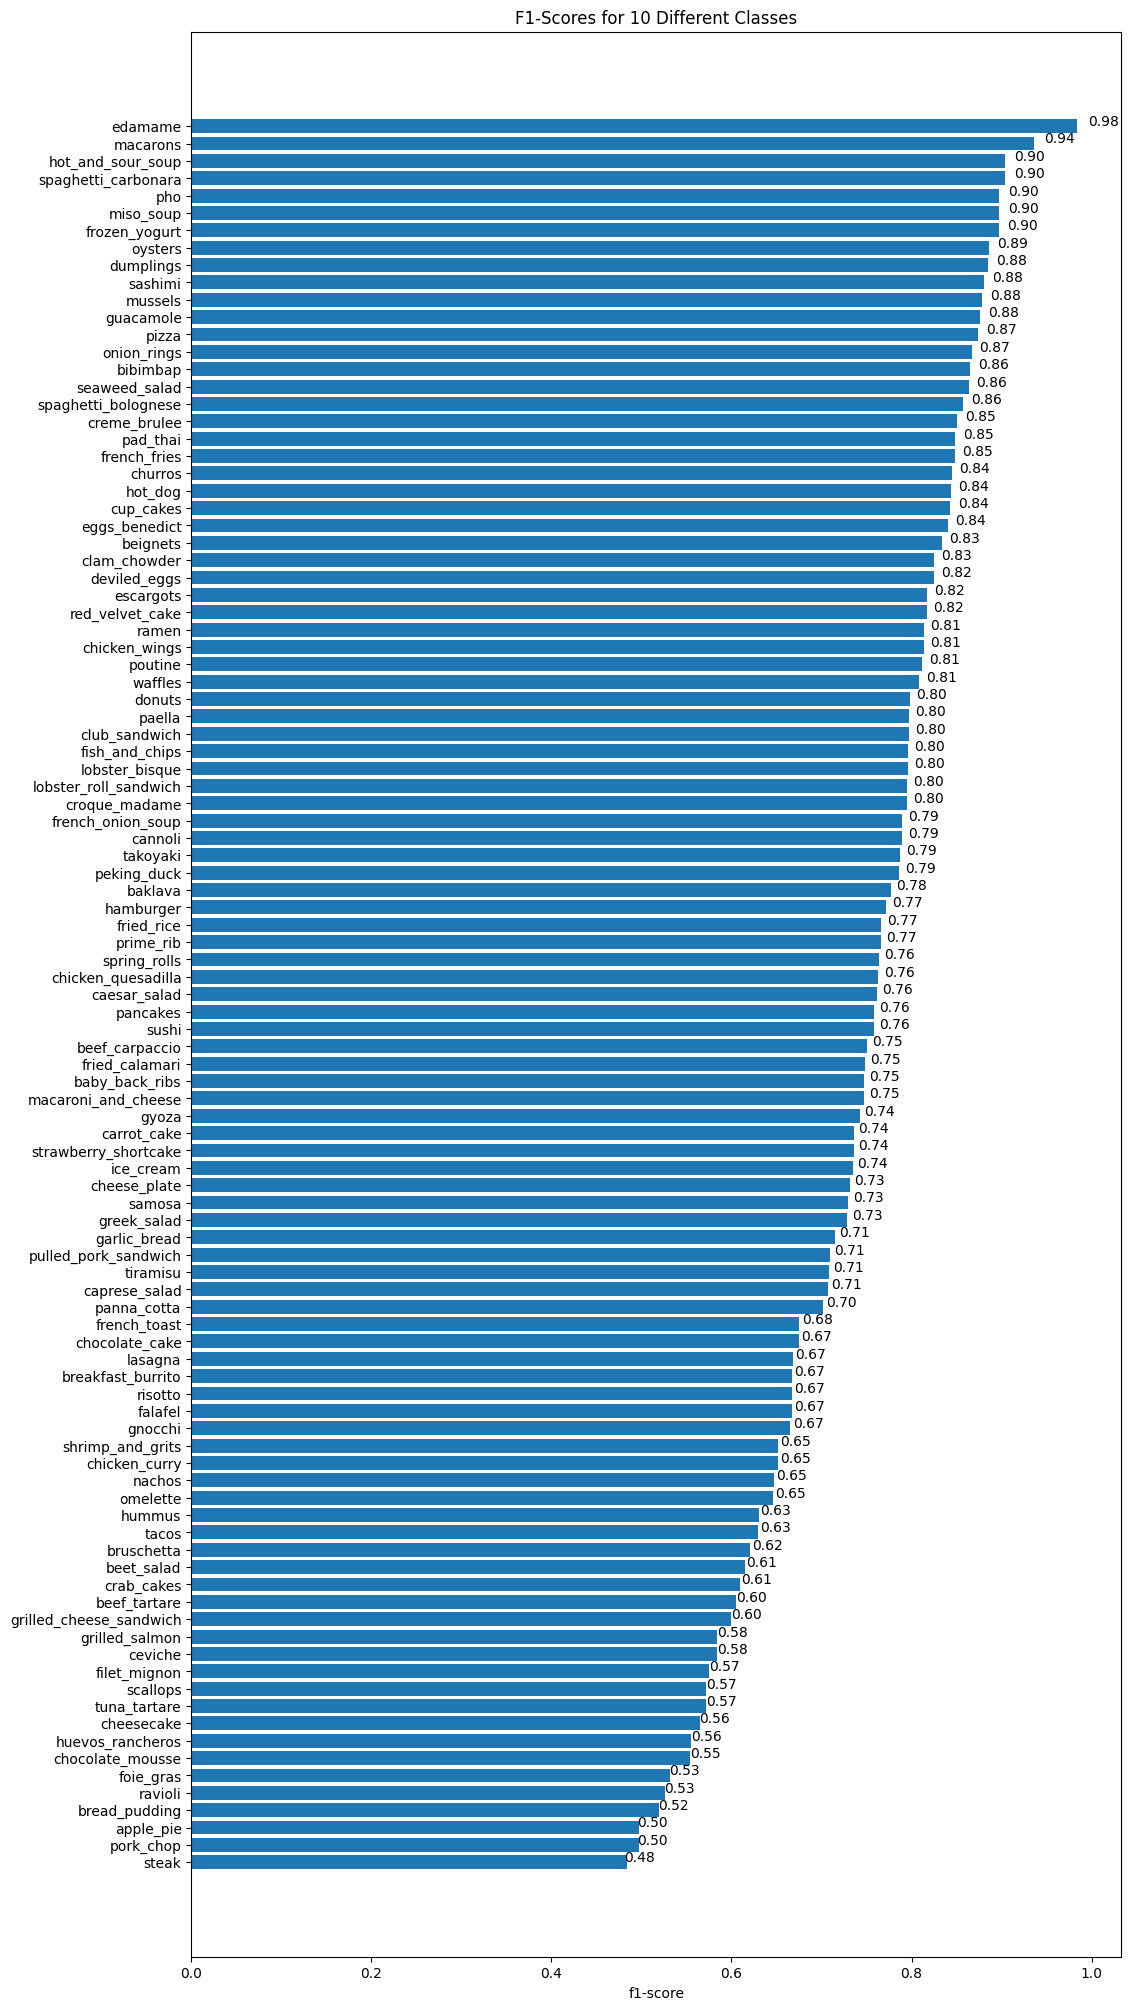

In [139]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)